# Bear type idetification

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search fastbook

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.2.1 which is incompatible.


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
urls = search_images_ddg('Grizzly', max_images=1)
urls[0]

'https://www.environews.tv/wp/wp-content/uploads/2016/03/Yellowstone-Grizzly-Bear-4.jpg'

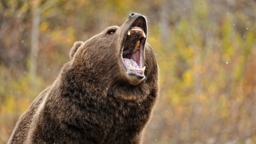

In [4]:
from fastdownload import download_url

dest = 'grizzly.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [5]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

from time import sleep

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents =True)
    download_images(dest, urls=search_images_ddg(f'{o} bear'))
    sleep(10)
    
    resize_images(path/o, max_size=400, dest=path/o)

In [6]:
fns = get_image_files(path)
fns

(#571) [Path('bears/teddy/1cd675b4-3b61-4b0a-bd2e-bd321aaab25c.jpg'),Path('bears/teddy/911e2d79-f4bf-436e-afd5-4d50a004be2c.jpg'),Path('bears/teddy/1f157a21-8516-4af1-9848-5d0b23477782.jpg'),Path('bears/teddy/61322d31-ddf0-4da7-8470-1b33f8c07fe3.jpg'),Path('bears/teddy/6fd21c7d-41f2-4276-8ac2-4f78dea4c387.jpg'),Path('bears/teddy/5d2692cf-cdf9-40de-bbcb-067a274b593a.jpg'),Path('bears/teddy/41a7190b-f854-46eb-9e5a-8a1ce50b9a59.jpg'),Path('bears/teddy/fe243804-2ad0-401b-8d1a-e56ade5dd061.jpg'),Path('bears/teddy/8af7795d-5896-49a9-8223-fc6363b768a8.jpg'),Path('bears/teddy/e4150496-e14e-47fa-ba00-2cb22dc40024.jpg')...]

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

28

In [8]:
fns = get_image_files(path)
fns

(#543) [Path('bears/teddy/911e2d79-f4bf-436e-afd5-4d50a004be2c.jpg'),Path('bears/teddy/1f157a21-8516-4af1-9848-5d0b23477782.jpg'),Path('bears/teddy/61322d31-ddf0-4da7-8470-1b33f8c07fe3.jpg'),Path('bears/teddy/6fd21c7d-41f2-4276-8ac2-4f78dea4c387.jpg'),Path('bears/teddy/5d2692cf-cdf9-40de-bbcb-067a274b593a.jpg'),Path('bears/teddy/41a7190b-f854-46eb-9e5a-8a1ce50b9a59.jpg'),Path('bears/teddy/fe243804-2ad0-401b-8d1a-e56ade5dd061.jpg'),Path('bears/teddy/8af7795d-5896-49a9-8223-fc6363b768a8.jpg'),Path('bears/teddy/e4150496-e14e-47fa-ba00-2cb22dc40024.jpg'),Path('bears/teddy/de684c41-d584-42fa-a125-6ee181097f94.jpg')...]

In [9]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = bears.dataloaders(path)

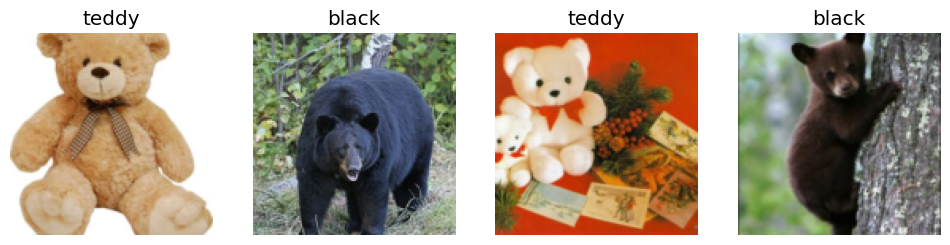

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

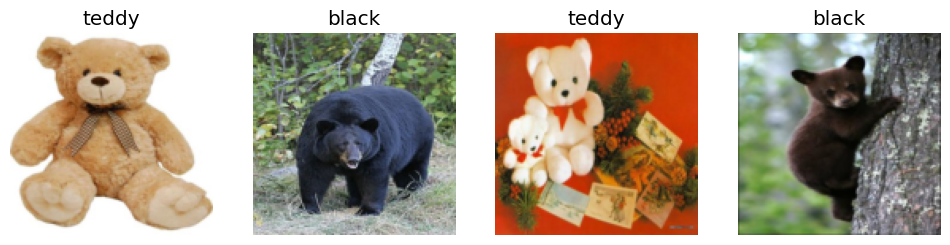

In [12]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

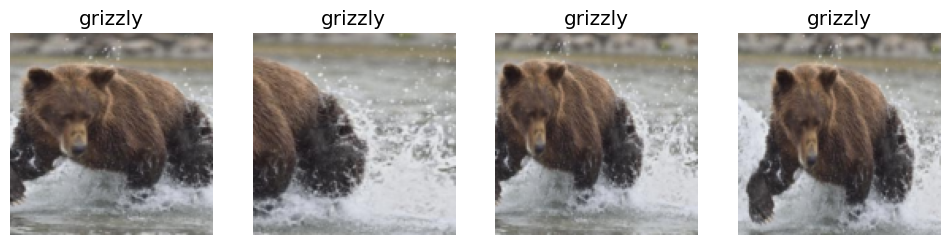

In [13]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation



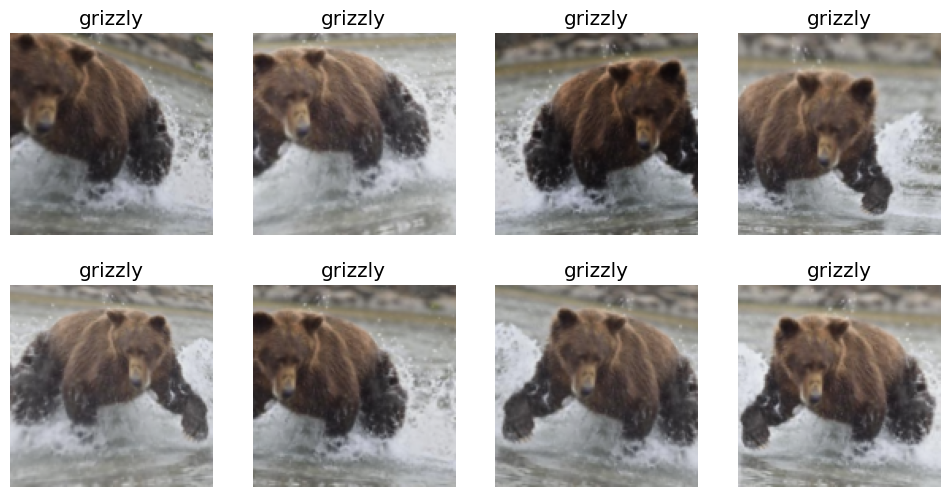

In [14]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=1))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [15]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.277208,0.267770,0.074074,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.197753,0.169057,0.055556,00:03
1,0.192835,0.158822,0.046296,00:03
2,0.152776,0.179575,0.037037,00:03
3,0.121833,0.177923,0.037037,00:03


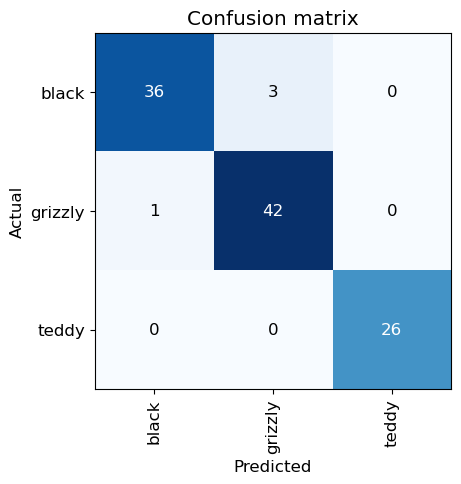

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

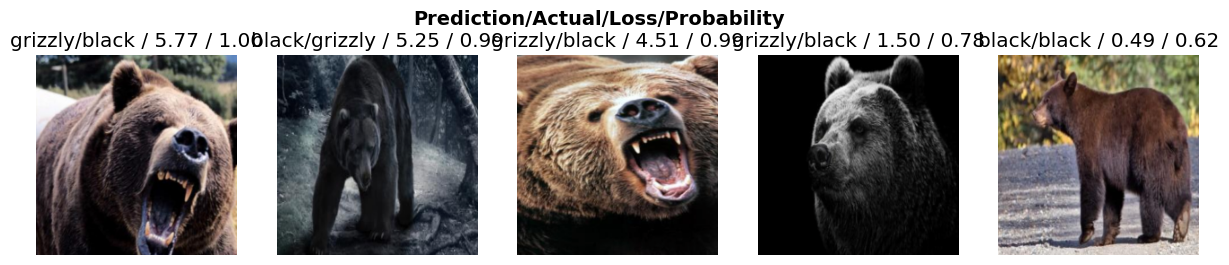

In [18]:
interp.plot_top_losses(5, nrows=1)

In [19]:
cleaner = ImageClassifierCleaner(learn)
cleaner


In [28]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [29]:
learn.export()

In [30]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [31]:
learn_inf = load_learner(path/'export.pkl')

In [32]:
learn_inf.predict('grizzly.jpg')

('grizzly', tensor(1), tensor([0.0010, 0.9977, 0.0012]))

In [33]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']